In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tabulate import tabulate as tab
import warnings
import generate_synthetic_data as gsd


## Read Data

In [2]:
# [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# data, labels = gsd.read_data_txt(IDs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
data, labels = gsd.read_data_txt(IDs = [1])

case    total    gammas    neutrons    ratio (g/n)    Amax total    Amax gammas    Amax neutrons
------  -------  --------  ----------  -------------  ------------  -------------  ---------------
case1   623142   511540    111602      4.6            1.6763        1.6763         0.7248
---     ---      ---       ---         ---            ---           ---            ---
Total   623142   511540    111602      4.6---         ---           ---


### Merge all cases together

In [3]:
data_merged, labels_merged, neutrons_merged, gammas_merged = gsd.merge_cases_together(data, labels)

## Templates

In [4]:
bin_edges = np.linspace(0.05, 0.5, 11) # 11 edges → 10 bins
# bin_edges = np.linspace(0.05, 0.5, 6) # 6 edges → 5 bins

In [5]:
print('Selection')
data_clean, labels_clean = gsd.pulse_selection_tight(data_merged, labels_merged)
neutrons_clean = data_clean[labels_clean == 1]
gammas_clean = data_clean[labels_clean == 0]
print('\nneutrons clean')
bin_centers_n_clean, templates_neutrons, templates_neutrons_norm = gsd.make_templates(neutrons_clean, bin_edges, align = True)
print('\ngammas clean')
_, templates_gammas, templates_gammas_norm = gsd.make_templates(gammas_clean, bin_edges, align = True)

bin_centers = bin_centers_n_clean

Selection
                    count    percentage of total [%]
------------------  -------  -------------------------
Ntot                623142
count_minThreshold  448931   72.0
count_maxThreshold  0        0.0
count_switch        0        0.0
count_beforePulses  1316     0.2
count_afterPulses   1458     0.2
---                 ---      ---
Nsel                171435   27.5

neutrons clean
 sample shape (10594, 296)
 peak amplitude (min, max) -0.0021 0.7248
 average peak amplitude 0.005327614432442639
 counts per bin: [5617 2617 1065  636  373  142   89   44    7    1]

gammas clean
 sample shape (160841, 296)
 peak amplitude (min, max) -0.0025 1.6763
 average peak amplitude 0.0029209297347035836
 counts per bin: [141539   5239   3536   2291   1547   1256   1005    692    662    590]


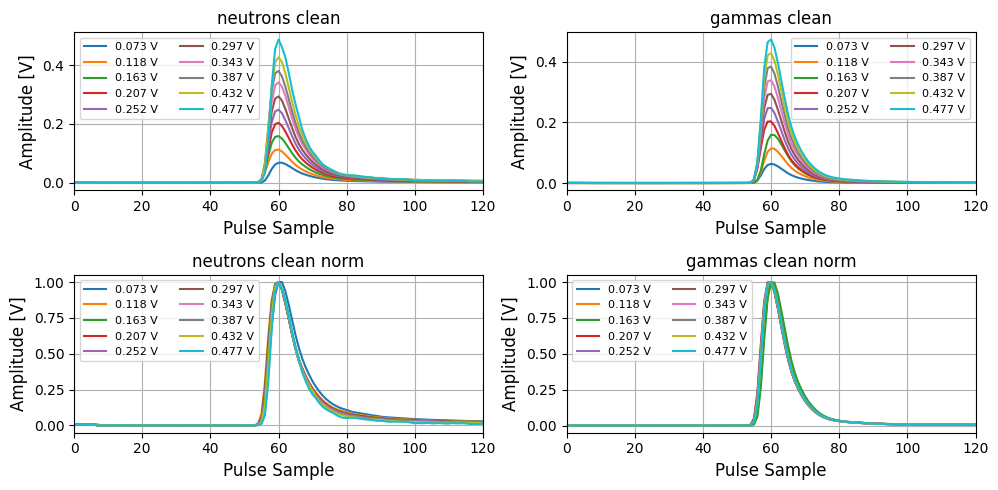

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

axs = axs.flatten()
axs[0].set_title(f'neutrons clean')
axs[1].set_title(f'gammas clean')
axs[2].set_title(f'neutrons clean norm')
axs[3].set_title(f'gammas clean norm')
for i in range(10):
    axs[0].plot(templates_neutrons[i], label=f"{bin_centers[i]:.3f} V")
    axs[1].plot(templates_gammas[i], label=f"{bin_centers[i]:.3f} V")
    axs[2].plot(templates_neutrons_norm[i], label=f"{bin_centers[i]:.3f} V")
    axs[3].plot(templates_gammas_norm[i], label=f"{bin_centers[i]:.3f} V")

for i in range(0, 4):
    axs[i].set_xlabel("Pulse Sample", fontsize=12)
    axs[i].set_ylabel("Amplitude [V]", fontsize=12)
    axs[i].legend(ncol=2, fontsize=8)
    axs[i].grid()
    axs[i].set_xlim(0, 120)
    # axs[i].set_ylim(0, 0.5)
plt.tight_layout()
plt.show()

# Pile up

In [7]:
print('n', templates_neutrons_norm.shape)
print('g', templates_gammas_norm.shape)

n (10, 296)
g (10, 296)


(0.0, 120.0)

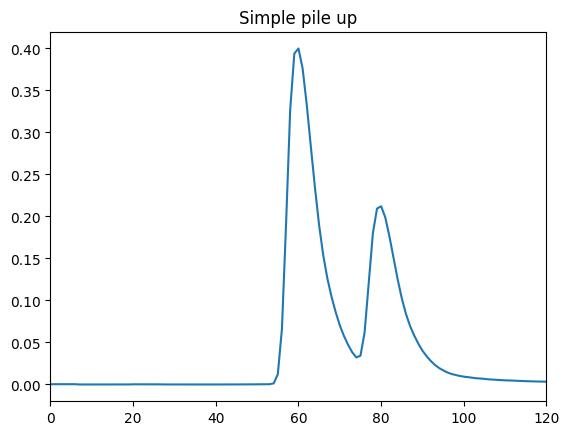

In [8]:
A1, A2 = 0.4, 0.2
shapes1, shapes2 = templates_gammas_norm, templates_gammas_norm
sigma = 0.0
time_shift = 20
pileup = gsd.generate_pileup_event(A1, A2, shapes1, shapes2, bin_centers, sigma, time_shift)
plt.plot(pileup)
plt.title('Simple pile up')
plt.xlim(0, 120)

### randomize A1 and A2

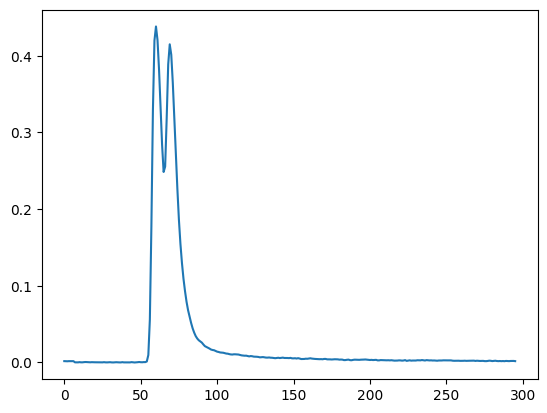

In [9]:
Npulses = 1
A_min, A_max = 0.05, 0.5
pileup = gsd.generate_pileup_event(A1 = np.random.uniform(A_min, A_max), 
                                   A2 = np.random.uniform(A_min, A_max),
                                   shapes1 = templates_neutrons_norm,
                                   shapes2 = templates_gammas_norm,
                                   bin_centers = bin_centers,
                                   noise_sigma = 0.0,
                                   time_shift = 10)
plt.plot(pileup)
# plt.xlim(0, 120)
plt.show()


## randomize in time (exponential)


### Probability of pile up

cf. Eq.(2) in paper

Poisson process

Probability of detecting a pile up pulse (pile up here is 2 pulses), within time interval $\Delta t$ and detector count rate (Hz) $r$

$$
P(r, \Delta t) = e^{-\mu} \times (1 - e^{-\mu})
$$

with $\mu = r \Delta t$

***Example*** - 20% of pile up

$P(r, \Delta t) = 0.20 \rightarrow \mu_{20\%} \approx 0.33$

$\Delta t = 592 \, \mathrm{n}s$ (trigger record length)

$\Rightarrow r = \dfrac{\mu_{20\%}}{\Delta t} \approx 5.6 \times 10^5 \, \mathrm{Hz}$

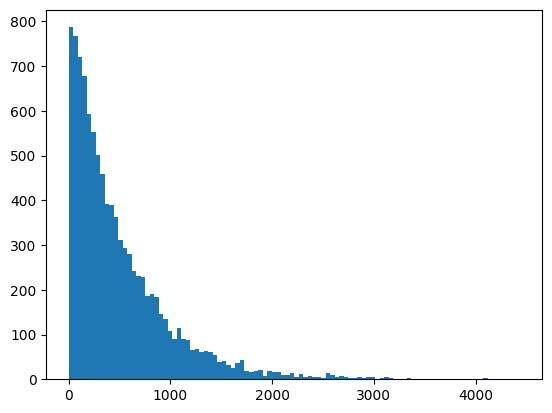

In [10]:
rate_hz = 1e6 # see example next section
dt_sample_s = 2e-9 # 2ns
dt_max_samples = 10000000 ## not sure if the proba is still ok if I put a max (window is now reduced...)
dts = [gsd.sample_dt_exponential(rate_hz, dt_sample_s, dt_max_samples) for i in range(10000)]
plt.hist(dts, bins = 100);

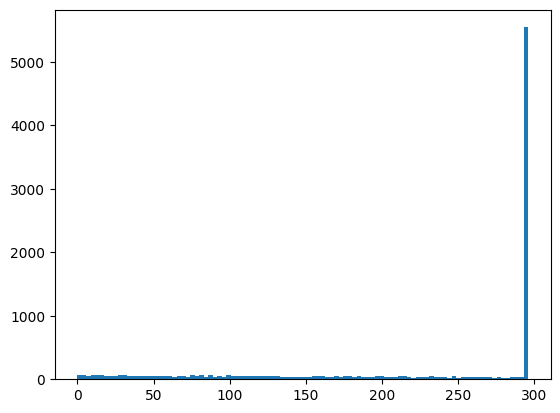

In [11]:
rate_hz = 1e6 # see example next section
dt_sample_s = 2e-9 # 2ns
dt_max_samples = data_merged.shape[1] ## not sure if the proba is still ok if I put a max (window is now reduced...)
dts = [gsd.sample_dt_exponential(rate_hz, dt_sample_s, dt_max_samples) for i in range(10000)]
plt.hist(dts, bins = 100);

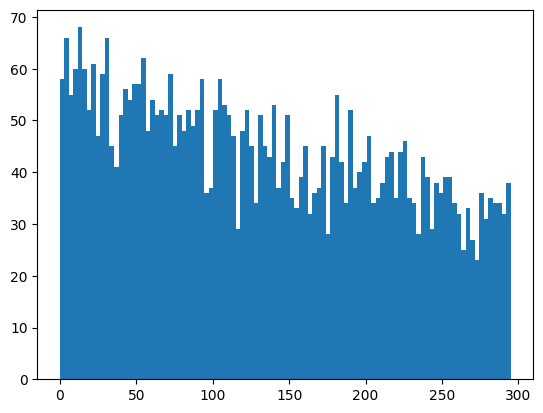

In [12]:
rate_hz = 1e6 # see example next section
dt_sample_s = 2e-9 # 2ns
dt_max_samples = data_merged.shape[1] ## not sure if the proba is still ok if I put a max (window is now reduced...)
dts = np.array([gsd.sample_dt_exponential(rate_hz, dt_sample_s, dt_max_samples) for i in range(10000)])
dts_masked = dts[dts < data_merged.shape[1]]
plt.hist(dts_masked, bins = 100);

### Fully Random

pulse 1: g, amplitude = 0.2910282920253863
pulse 2: g, amplitude = 0.31324625877145296
time_shift = 215 samples


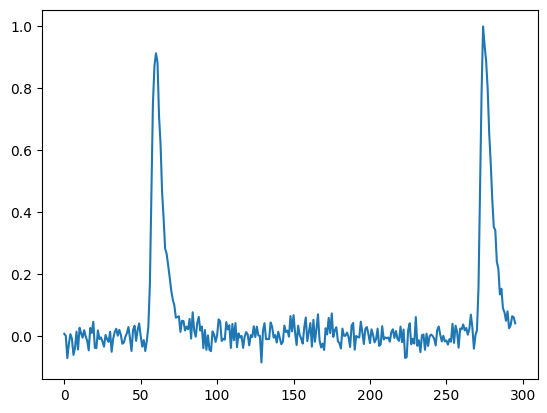

In [19]:
pileup = gsd.generate_random_pileup_event(
        neutron_templates_normalized = templates_neutrons_norm, 
        gamma_templates_normalized= templates_gammas_norm, 
        bin_centers = bin_centers,
        A_min = 0.05, A_max = 0.5, # min and max for the pulse amplitudes
        rate_hz = 1e6, dt_sample_s = 2e-9, dt_max_samples = 296, # time shift
        noise_sigma = 0.01, # Guassian noise
        Normalize=True,
        debug = True
        )

plt.plot(pileup)
# plt.xlim(0, 120)
plt.show()

# PSD with pileup (just for fun)

NEUTRONS: 50000
Clamped fraction: 0.04924
GAMMAS: 50000
Clamped fraction: 0.05008
PILEUP: 25000
all data (125000, 296)


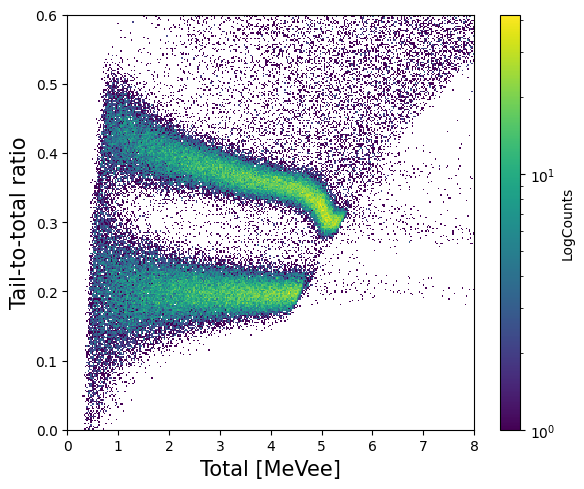

In [27]:
# sigma_noise = 0.001
# sigma_noise = 0.0025
sigma_noise = 0.005
# sigma_noise = 0.01

min_voltage = 0.05
max_voltage = 0.5 ## cannot go too high because PSD gets distorted

Npulses_n  = 50000
Npulses_g  = 50000
Npulses_pu = 25000

print(f'NEUTRONS: {Npulses_n}')
neutrons_synth, _ = gsd.generate_sample(templates = templates_neutrons_norm, 
                                 bin_centers =  bin_centers, 
                                 Npulses = Npulses_n, 
                                 sigma = sigma_noise,
                                 A_min=min_voltage, 
                                 A_max=max_voltage,
                                 Normalize=False) # if True PSD doesn't work
print(f'GAMMAS: {Npulses_g}')
gammas_synth, _ = gsd.generate_sample(templates = templates_gammas_norm, 
                                 bin_centers =  bin_centers, 
                                 Npulses = Npulses_g, 
                                 sigma = sigma_noise,
                                 A_min=min_voltage, 
                                 A_max=max_voltage,
                                 Normalize=False) # if True PSD doesn't work
print(f'PILEUP: {Npulses_pu}')
piluep_synth = gsd.generate_pileup_sample(
    Npulses = Npulses_pu,
    neutron_templates_normalized = templates_neutrons_norm, 
    gamma_templates_normalized = templates_gammas_norm, 
    bin_centers = bin_centers,
    A_min = min_voltage, A_max = max_voltage, 
    rate_hz = 1e6, dt_sample_s = 2e-9, dt_max_samples = 296, # time shift
    noise_sigma = sigma_noise,
    Normalize=False
    )

data_synth = np.concatenate((neutrons_synth, gammas_synth, piluep_synth), axis=0)
print('all data', data_synth.shape)

totals,ttr = gsd.get_psd_integrals(data_synth)
plt.figure(figsize=(6, 5))

# no cuts
plt.hist2d(
    totals,
    ttr,
    bins=[300, 300],
    range=[[0, 8], [0, 0.6]],
    norm=LogNorm(),
    cmap="viridis"
)

plt.colorbar(label="LogCounts")
plt.xlabel('Total [MeVee]', fontsize = 15)
plt.ylabel("Tail-to-total ratio", fontsize = 15)
plt.tight_layout()
plt.show()